In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Activation funcs

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return 2 / (1 + np.exp(-2 * x)) - 1

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - x ** 2

# Layers

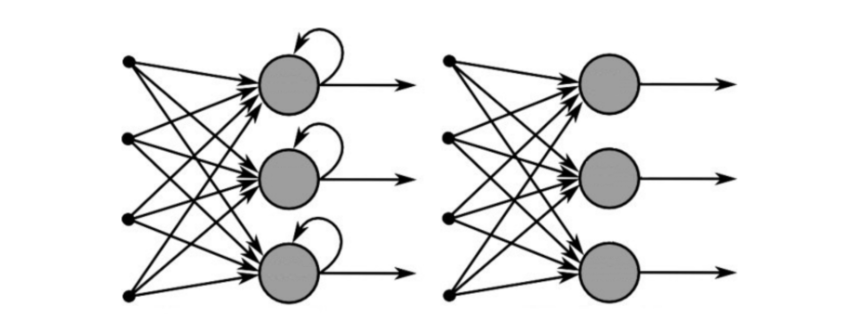

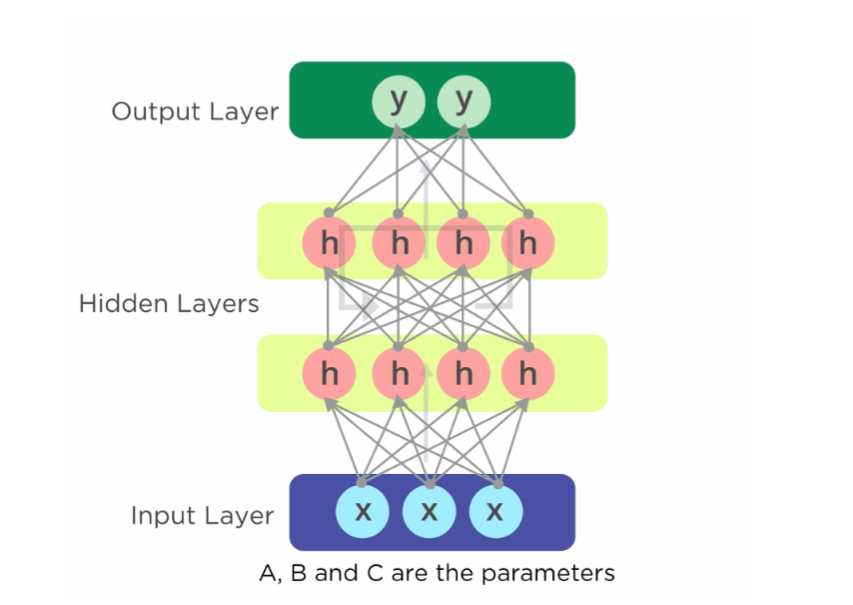

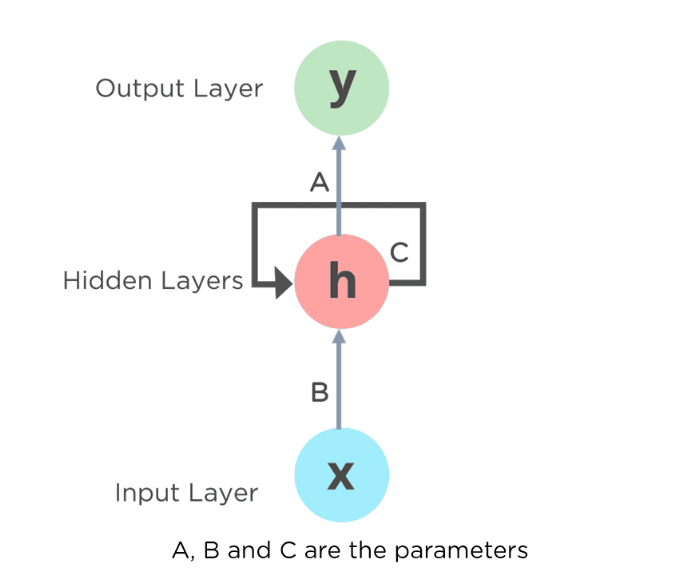

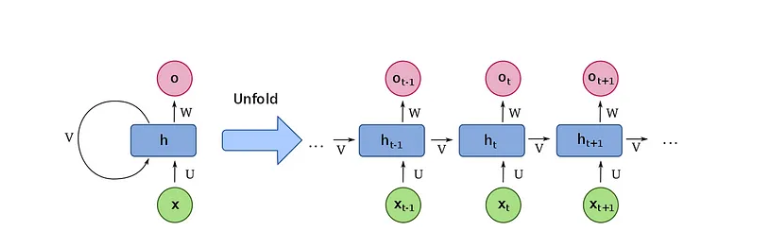
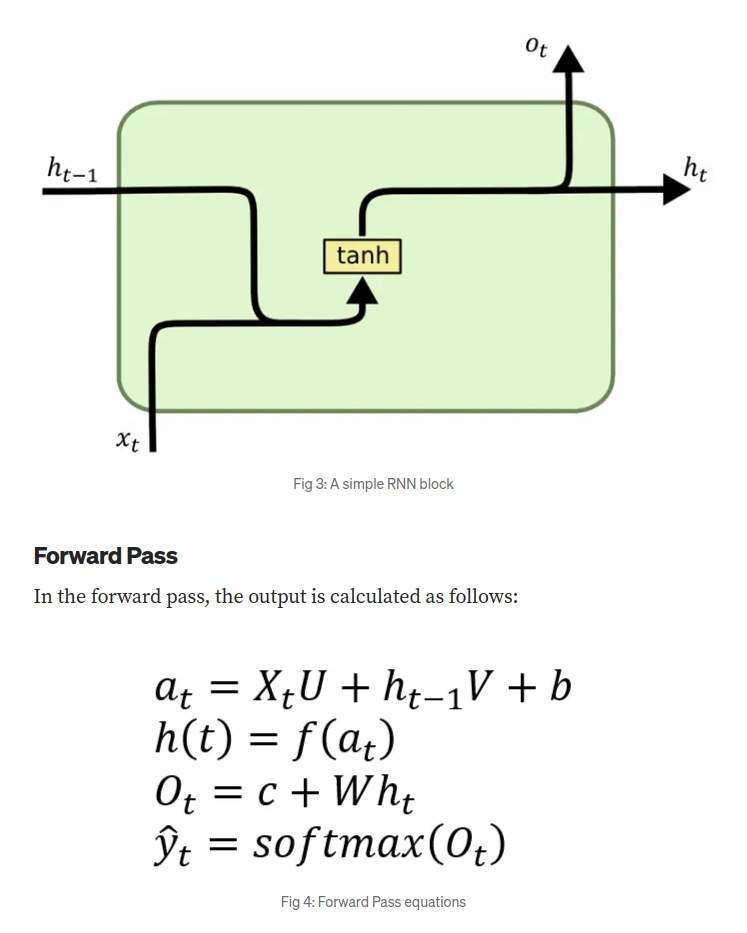

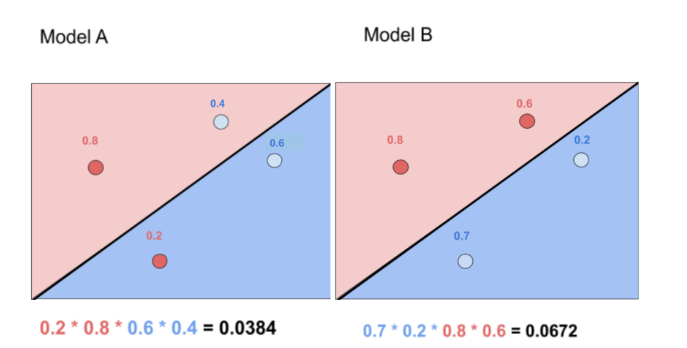

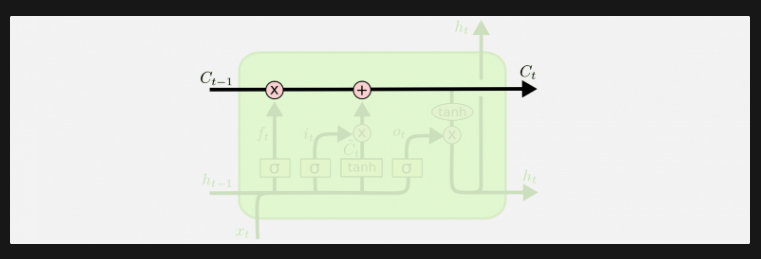

In [ ]:
class AbstractLayer:
    def __init__(self, activation = 'relu'):
        self.activation = None
        if activation == 'relu':
            self.activation = ReLU()
        elif activation == 'softmax':
            self.activation = Softmax()

    def forward(self, input_data):
        pass

    def backward(self, output_gradient, learning_rate):
        pass


class RNN(AbstractLayer):
    def __init__(self, input_size, output_size, return_sequence = False, activation = 'relu'):
        super().__init__(activation)
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.return_sequence = return_sequence
        self.ws = 0.2

        self.input_data = None
        self.hiddens = None

        self.input_weights = None
        self.hidden_weights = None
        self.output_weights = None
        self.hidden_bias = None
        self.output_bias = None

        if self.input_size is not None:
            self.create_weights()

    def create_weights(self):
        self.input_weights = np.random.uniform(-self.ws, self.ws, size = (self.input_size, self.hidden_size))
        self.hidden_weights = np.random.uniform(-self.ws, self.ws, size = (self.hidden_size, self.hidden_size))
        self.output_weights = np.random.uniform(-self.ws, self.ws, size = (self.hidden_size, self.output_size))
        self.hidden_bias = np.zeros(self.hidden_size)
        self.output_bias = np.zeros(self.output_size)

    def forward(self, input_data):
        if self.input_size is None:
            self.input_size = input_data.shape[-1]
            self.create_weights()

        self.input_data = input_data
        batch_size, sequence_length, _ = input_data.shape
        hidden = np.zeros((batch_size, self.hidden_size))
        self.hiddens = np.zeros((batch_size, sequence_length, self.hidden_size))

        input_x = np.dot(input_data, self.input_weights)
        for i in range(sequence_length):
            hidden = input_x[:, i, :] + np.dot(hidden, self.hidden_weights) + self.hidden_bias
            hidden = tanh(hidden)
            self.hiddens[:, i, :] = hidden

        if self.return_sequence:
            output = np.dot(self.hiddens, self.output_weights) + self.output_bias
        else:
            final_hidden_state = self.hiddens[:, -1, :]
            output = np.dot(final_hidden_state, self.output_weights) + self.output_bias

        return output

    def backward(self, d_out, learning_rate):
        batch_size, sequence_length, _ = self.input_data.shape

        input_weights_gradient = np.zeros_like(self.input_weights)
        hidden_weights_gradient = np.zeros_like(self.hidden_weights)
        output_weights_gradient = np.zeros_like(self.output_weights)
        output_bias_gradient = np.zeros_like(self.output_bias)
        hidden_bias_gradient = np.zeros_like(self.hidden_bias)

        hidden_error_gradient = np.zeros((batch_size, self.hidden_size))

        d_in = np.zeros_like(self.input_data)

        for i in reversed(range(sequence_length)):
            hidden_i = self.hiddens[:, i, :]

            if self.return_sequence:
                l_grad_i = d_out[:, i, :]
                output_weights_gradient += np.dot(hidden_i.T, l_grad_i)
                output_bias_gradient += np.mean(l_grad_i, axis=0)

                hidden_error = np.dot(l_grad_i, self.output_weights.T) + hidden_error_gradient
            else:
                if i == sequence_length - 1:
                    l_grad_i = d_out
                    output_weights_gradient += np.dot(hidden_i.T, l_grad_i)
                    output_bias_gradient += np.mean(l_grad_i, axis=0)

                    hidden_error = np.dot(l_grad_i, self.output_weights.T)
                else:
                    hidden_error = hidden_error_gradient

            hidden_derivative = tanh_derivative(hidden_i)
            h_grad_i = hidden_derivative * hidden_error

            if i > 0:
                hidden_weights_gradient += np.dot(self.hiddens[:, i - 1, :].T, h_grad_i)
                hidden_bias_gradient += np.mean(h_grad_i, axis=0)

            input_x = self.input_data[:, i, :]
            input_weights_gradient += np.dot(input_x.T, h_grad_i)

            hidden_error_gradient = np.dot(h_grad_i, self.hidden_weights.T)

            d_in[:, i, :] = np.dot(h_grad_i, self.input_weights.T)

        self.input_weights -= learning_rate * input_weights_gradient / batch_size
        self.hidden_weights -= learning_rate * hidden_weights_gradient / batch_size
        self.output_weights -= learning_rate * output_weights_gradient / batch_size
        self.hidden_bias -= learning_rate * hidden_bias_gradient / batch_size
        self.output_bias -= learning_rate * output_bias_gradient / batch_size

        return d_in


class DenseLayer(AbstractLayer):
    def __init__(self, input_size = None, output_size = 10, activation = 'relu'):
        super().__init__(activation)
        self.ws = 0.2
        self.x = None
        self.weights = None
        self.output_size = output_size
        if input_size is not None:
            self.weights = np.random.randn(input_size, output_size) * self.ws
        self.bias = np.zeros((1, output_size))

    def forward(self, x):
        if self.weights is None:
            input_size = x.shape[-1]
            self.weights = np.random.randn(input_size, self.output_size) * self.ws

        self.x = x
        output_data = np.dot(x, self.weights) + self.bias
        return output_data

    def backward(self, output_gradient, learning_rate):
        dx = np.dot(output_gradient, self.weights.T)
        dw = np.dot(self.x.T, output_gradient)
        db = np.sum(output_gradient, axis = 0)
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db
        return dx


class ReLU:
    def __init__(self):
        super().__init__()
        self.output_data = None

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        self.output_data = np.maximum(0, input_data)
        return self.output_data

    def backward(self, d_output: np.ndarray, **kwargs) -> np.ndarray:
        return d_output * (self.output_data > 0)


class Softmax:
    def __init__(self):
        super().__init__()
        self.output_data = None

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        exp_values = np.exp(input_data - np.max(input_data, axis = -1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = -1, keepdims = True)
        self.output_data = probabilities
        return self.output_data

    def backward(self, d_output: np.ndarray, **kwargs) -> np.ndarray:
        return d_output


class CategoricalCrossEntropy:
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        epsilon = 1e-15
        clipped_y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(clipped_y_pred)) / y_pred.shape[0]

    def gradient(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        epsilon = 1e-15
        clipped_y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -(y_true - clipped_y_pred) / y_pred.shape[0]


class Network:
    def __init__(self, loss_function, learning_rate, epochs):
        self.layers = []
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.epochs = epochs

    def append(self, layer):
        self.layers.append(layer)
        if layer.activation is not None:
            self.layers.append(layer.activation)
        return self

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data

    def backward(self, d_output, learning_rate) -> None:
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate=learning_rate)

    def train(self, x_train_data, y_train_data, learning_rate,
              batch_size=32) -> None:

        data_size = len(x_train_data)
        for epoch in range(32):
            indices = np.random.permutation(data_size)
            x_train_data_shuffled = x_train_data[indices]
            y_train_data_shuffled = y_train_data[indices]

            mean_loss_train = 0.0
            for batch_start in range(0, data_size, batch_size):
                batch_end = min(batch_start + batch_size, data_size)
                x_batch = x_train_data_shuffled[batch_start:batch_end]
                y_batch = y_train_data_shuffled[batch_start:batch_end]

                predictions_train = self.forward(x_batch)
                mean_loss_train += self.loss_function(y_batch, predictions_train)
                d_output_train = self.loss_function.gradient(y_batch, predictions_train)
                self.backward(d_output_train, learning_rate)

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        return self.forward(x_test)


class LSTM(AbstractLayer):
    def __init__(self, input_size, output_size, return_sequence=False, activation='relu'):
        super().__init__(activation)
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.return_sequence = return_sequence
        self.ws = 0.3

        self.x = None
        self.hs = None
        self.cs = None
        self.os = None
        self.fs = None
        self.ins = None
        self._cs = None
        self.c_tanh = None

        if self.input_size is not None:
            self.create_weights()

    def create_weights(self):
        self.Wi = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Ui = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bi = np.zeros(self.hidden_size)

        self.Wf = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uf = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bf = np.zeros(self.hidden_size)

        self.Wo = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uo = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bo = np.zeros(self.hidden_size)

        self.Wc = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uc = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bc = np.zeros(self.hidden_size)

        self.Wy = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.output_size))
        self.by = np.zeros(self.output_size)

    def forward(self, x):
        if self.input_size is None:
            self.input_size = x.shape[-1]
            self._init_weights()

        batch_size, sequence_length, _ = x.shape
        self.x = x

        ht = np.zeros((batch_size, self.hidden_size))
        ct = np.zeros((batch_size, self.hidden_size))

        self.hs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.cs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.ins = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.os = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.fs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self._cs = np.zeros((batch_size, sequence_length, self.hidden_size))
        self.c_tanh = np.zeros((batch_size, sequence_length, self.hidden_size))

        for t in range(sequence_length):
            xt = x[:, t, :]
            it = sigmoid(xt @ self.Wi + ht @ self.Ui + self.bi)
            ft = sigmoid(xt @ self.Wf + ht @ self.Uf + self.bf)
            ot = sigmoid(xt @ self.Wo + ht @ self.Uo + self.bo)
            _c = tanh(xt @ self.Wc + ht @ self.Uc + self.bc)

            self.ins[:, t, :] = it
            self.os[:, t, :] = ot
            self.fs[:, t, :] = ft
            self._cs[:, t, :] = _c

            ct = ft * ct + it * _c
            self.cs[:, t, :] = ct

            self.c_tanh[:, t, :] = tanh(ct)
            ht = ot * self.c_tanh[:, t, :]
            self.hs[:, t, :] = ht

        if self.return_sequence:
            output = self.hs @ self.Wy + self.by
        else:
            final_hidden_state = self.hs[:, -1, :]
            output = final_hidden_state @ self.Wy + self.by

        return output

    def backward(self, dY, learning_rate):
        batch_size, sequence_length, _ = self.x.shape

        dWi, dUi, dbi = np.zeros_like(self.Wi), np.zeros_like(self.Ui), np.zeros_like(self.bi)
        dWf, dUf, dbf = np.zeros_like(self.Wf), np.zeros_like(self.Uf), np.zeros_like(self.bf)
        dWo, dUo, dbo = np.zeros_like(self.Wo), np.zeros_like(self.Uo), np.zeros_like(self.bo)
        dWc, dUc, dbc = np.zeros_like(self.Wc), np.zeros_like(self.Uc), np.zeros_like(self.bc)
        dWy, dby = np.zeros_like(self.Wy), np.zeros_like(self.by)

        dh_next = np.zeros((batch_size, self.hidden_size))
        dc_next = np.zeros((batch_size, self.hidden_size))

        dX = np.zeros((batch_size, sequence_length, self.input_size))

        for t in reversed(range(sequence_length)):
            dy = dY[:, t, :] if self.return_sequence else (dY if t == sequence_length - 1 else np.zeros_like(dY))

            dWy += self.hs[:, t, :].T @ dy
            dby += np.sum(dy, axis=0)
            dh = dy @ self.Wy.T + dh_next
            dc = self.os[:, t, :] * dh * tanh_derivative(self.cs[:, t, :]) + dc_next
            dot = sigmoid_derivative(self.os[:, t, :]) * self.c_tanh[:, t, :] * dh

            if t > 0:
                dft = self.cs[:, t - 1, :] * dc * sigmoid_derivative(self.fs[:, t, :])
            else:
                dft = np.zeros_like(self.fs[:, t, :])

            dit = self._cs[:, t, :] * dc * sigmoid_derivative(self.ins[:, t, :])
            dct = self.ins[:, t, :] * dc * tanh_derivative(self._cs[:, t, :])
            dWi += self.x[:, t, :].T @ dit
            dbi += np.sum(dit, axis=0)

            dWf += self.x[:, t, :].T @ dft
            dbf += np.sum(dft, axis=0)

            dWo += self.x[:, t, :].T @ dot
            dbo += np.sum(dot, axis=0)

            dWc += self.x[:, t, :].T @ dct
            dbc += np.sum(dct, axis=0)

            if t > 0:
                dUi += self.hs[:, t - 1, :].T @ dit
                dUf += self.hs[:, t - 1, :].T @ dft
                dUo += self.hs[:, t - 1, :].T @ dot
                dUc += self.hs[:, t - 1, :].T @ dct

            dh_next = dit @ self.Ui.T + dft @ self.Uf.T + dot @ self.Uo.T + dct @ self.Uc.T
            dc_next = self.fs[:, t, :] * dc

            dX[:, t, :] = dit @ self.Wi.T + dft @ self.Wf.T + dot @ self.Wo.T + dct @ self.Wc.T

        self.Wi -= learning_rate * dWi / batch_size
        self.Ui -= learning_rate * dUi / batch_size
        self.bi -= learning_rate * dbi / batch_size
        self.Wf -= learning_rate * dWf / batch_size
        self.Uf -= learning_rate * dUf / batch_size
        self.bf -= learning_rate * dbf / batch_size
        self.Wo -= learning_rate * dWo / batch_size
        self.Uo -= learning_rate * dUo / batch_size
        self.bo -= learning_rate * dbo / batch_size
        self.Wc -= learning_rate * dWc / batch_size
        self.Uc -= learning_rate * dUc / batch_size
        self.bc -= learning_rate * dbc / batch_size
        self.Wy -= learning_rate * dWy / batch_size
        self.by -= learning_rate * dby / batch_size

        return dX


class GRU(AbstractLayer):
    def __init__(self, input_size, output_size, return_sequence = False, activation = 'relu'):
        super().__init__(activation)
        self.input_size = input_size
        self.hidden_size = input_size
        self.output_size = output_size
        self.return_sequence = return_sequence
        self.ws = 0.3

        self.x = None
        self.z = None
        self.r = None
        self.h = None
        self.h_hat = None

        if self.input_size is not None:
            self.create_weights()

    def create_weights(self):
        self.Wz = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))  # noqa
        self.Uz = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bz = np.zeros(self.hidden_size)
        self.Wr = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Ur = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.br = np.zeros(self.hidden_size)
        self.Wh = np.random.uniform(-self.ws, self.ws, (self.input_size, self.hidden_size))
        self.Uh = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.hidden_size))
        self.bh = np.zeros(self.hidden_size)
        self.Wy = np.random.uniform(-self.ws, self.ws, (self.hidden_size, self.output_size))
        self.by = np.zeros(self.output_size)

    def forward(self, x):
        if self.input_size is None:
            self.input_size = x.shape[-1]
            self._init_weights()

        batch_size, sequence_length, _ = x.shape
        self.x = x

        h = np.zeros((batch_size, sequence_length, self.hidden_size))
        z = np.zeros((batch_size, sequence_length, self.hidden_size))
        r = np.zeros((batch_size, sequence_length, self.hidden_size))
        h_hat = np.zeros((batch_size, sequence_length, self.hidden_size))

        for t in range(sequence_length):
            prev_h = h[:, t - 1, :] if t > 0 else np.zeros_like(h[:, 0, :])
            z[:, t, :] = sigmoid(x[:, t, :] @ self.Wz + prev_h @ self.Uz + self.bz)
            r[:, t, :] = sigmoid(x[:, t, :] @ self.Wr + prev_h @ self.Ur + self.br)
            h_hat[:, t, :] = tanh(x[:, t, :] @ self.Wh + (r[:, t, :] * prev_h) @ self.Uh + self.bh)
            h[:, t, :] = z[:, t, :] * prev_h + (1 - z[:, t, :]) * h_hat[:, t, :]

        self.z = z
        self.r = r
        self.h = h
        self.h_hat = h_hat

        if self.return_sequence:
            o_t = self.h @ self.Wy + self.by
            return o_t

        o_t = self.h[:, -1, :] @ self.Wy + self.by
        return o_t

    def backward(self, dY, learning_rate=0.01):
        batch_size, sequence_length, _ = self.x.shape

        dWz, dUz, dbz = np.zeros_like(self.Wz), np.zeros_like(self.Uz), np.zeros_like(self.bz)
        dWr, dUr, dbr = np.zeros_like(self.Wr), np.zeros_like(self.Ur), np.zeros_like(self.br)
        dWh, dUh, dbh = np.zeros_like(self.Wh), np.zeros_like(self.Uh), np.zeros_like(self.bh)
        dWy, dby = np.zeros_like(self.Wy), np.zeros_like(self.by)

        dh_next = np.zeros((batch_size, self.hidden_size))

        dX = np.zeros((batch_size, sequence_length, self.input_size))

        for t in reversed(range(sequence_length)):
            dy = dY[:, t, :] if self.return_sequence else (dY if t == sequence_length - 1 else np.zeros_like(dY))

            dWy += self.h[:, t, :].T @ dy
            dby += np.sum(dy, axis=0)

            dh = dy @ self.Wy.T + dh_next
            dh_hat = np.multiply(dh, (1 - self.z[:, t, :]))
            dh_hat_l = dh_hat * tanh_derivative(self.h_hat[:, t, :])

            dWh += np.dot(self.x[:, t, :].T, dh_hat_l)
            dUh += np.dot(np.multiply(self.r[:, t, :], self.h[:, t - 1, :]).T, dh_hat_l)
            dbh += np.sum(dh_hat_l, axis=0)

            drhp = np.dot(dh_hat_l, self.Uh.T)
            dr = np.multiply(drhp, self.h[:, t - 1, :])
            dr_l = dr * sigmoid_derivative(self.r[:, t, :])

            dWr += np.dot(self.x[:, t, :].T, dr_l)
            dUr += np.dot(self.h[:, t - 1, :].T, dr_l)
            dbr += np.sum(dr_l, axis=0)

            dz = np.multiply(dh, self.h[:, t - 1, :] - self.h_hat[:, t, :])
            dz_l = dz * sigmoid_derivative(self.z[:, t, :])

            dWz += np.dot(self.x[:, t, :].T, dz_l)
            dUz += np.dot(self.h[:, t - 1, :].T, dz_l)
            dbz += np.sum(dz_l, axis=0)

            dh_fz_inner = np.dot(dz_l, self.Uz.T)
            dh_fz = np.multiply(dh, self.z[:, t, :])
            dh_fhh = np.multiply(drhp, self.r[:, t, :])
            dh_fr = np.dot(dr_l, self.Ur.T)

            dh_next = dh_fz_inner + dh_fz + dh_fhh + dh_fr

            dX[:, t, :] = dz_l @ self.Wz.T + dr_l @ self.Wr.T + dh_hat_l @ self.Wh.T

        self.Wz -= learning_rate * dWz / batch_size
        self.Uz -= learning_rate * dUz / batch_size
        self.bz -= learning_rate * dbz / batch_size
        self.Wr -= learning_rate * dWr / batch_size
        self.Ur -= learning_rate * dUr / batch_size
        self.br -= learning_rate * dbr / batch_size
        self.Wh -= learning_rate * dWh / batch_size
        self.Uh -= learning_rate * dUh / batch_size
        self.bh -= learning_rate * dbh / batch_size
        self.Wy -= learning_rate * dWy / batch_size
        self.by -= learning_rate * dby / batch_size

        return dX

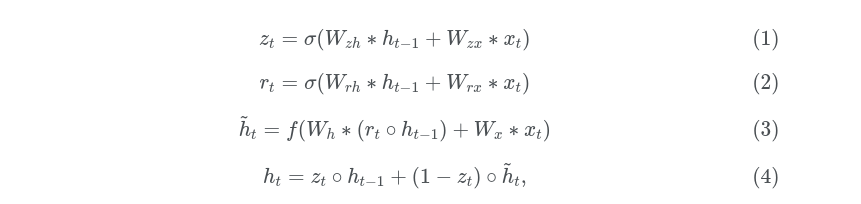

# Creation model and train it

In [ ]:
data = pd.read_csv('Steel_industry_data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
np.set_printoptions(linewidth = 1000)
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [ ]:
data['date'] = pd.to_datetime(data['date'], dayfirst = True)
data.sort_values(by = 'date', inplace = True)

data['day'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['time'] = data['date'].dt.time
data = data.drop(columns = ['date', 'WeekStatus', 'Day_of_week'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   Load_Type                             35040 non-null  object 
 8   day                                   35040 non-null  int32  
 9   month                                 35040 non-null  int32  
 10  time                                  35040 non-null  object 
dtypes: float64(6), int3

In [ ]:
data.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type,day,month,time
95,3.42,3.46,0.0,0.0,70.30,100.0,0,Light_Load,0,1,00:00:00
0,3.17,2.95,0.0,0.0,73.21,100.0,900,Light_Load,0,1,00:15:00
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,Light_Load,0,1,00:30:00
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,Light_Load,0,1,00:45:00
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,Light_Load,0,1,01:00:00


In [ ]:
def timestamp_transform(val):
  return val.hour * 3600 + val.minute * 60 + val.second

data['TimeStamp'] = data['time'].apply(timestamp_transform)
data = data.drop(columns = ['time'])
data.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type,day,month,TimeStamp
95,3.42,3.46,0.0,0.0,70.30,100.0,0,Light_Load,0,1,0
0,3.17,2.95,0.0,0.0,73.21,100.0,900,Light_Load,0,1,900
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,Light_Load,0,1,1800
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,Light_Load,0,1,2700
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,Light_Load,0,1,3600


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def dataset_preprocessing(x_data, y_data, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    indices = np.arange(len(x_data))
    np.random.shuffle(indices)

    test_samples = int(len(x_data) * test_size)

    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    if isinstance(x_data, pd.DataFrame):
        x_train_data, x_test_data = x_data.iloc[train_indices], x_data.iloc[test_indices]
    elif isinstance(x_data, np.ndarray):
        x_train_data, x_test_data = x_data[train_indices], x_data[test_indices]
    else:
        raise ValueError("Unsupported type for 'x'. Use pandas DataFrame or NumPy array.")

    if isinstance(y_data, pd.Series):
        y_train_data, y_test_data = y_data.iloc[train_indices], y_data.iloc[test_indices]
    elif isinstance(y_data, np.ndarray):
        y_train_data, y_test_data = y_data[train_indices], y_data[test_indices]
    else:
        raise ValueError("Unsupported type for 'y'. Use pandas Series or NumPy array.")

    return x_train_data, x_test_data, y_train_data, y_test_data


scaler = StandardScaler()
numeric_features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'TimeStamp']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

label_encoder = LabelEncoder()
data['Load_Type'] = label_encoder.fit_transform(data['Load_Type'])

data.info()

x = data.drop(columns='Load_Type').values
y = pd.get_dummies(data['Load_Type']).values

seq_len = 7
sequence_length = 4
X_seq = []
Y_seq = []

for i in range(len(x) - seq_len):
    X_seq.append(x[i:i + seq_len])
    Y_seq.append(y[i + seq_len])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

x_train, x_test, y_train, y_test = dataset_preprocessing(X_seq, Y_seq, test_size = 0.1, random_state = 42)

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  float64
 7   Load_Type                             35040 non-null  int64  
 8   day                                   35040 non-null  int32  
 9   month                                 35040 non-null  int32  
 10  TimeStamp                             35040 non-null  float64
dtypes: float64(8), int3

# RNN

# Metrics multi-models

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_recall(y_true, y_pred):
    num_classes = y_true.shape[1]
    recalls = []

    for class_index in range(num_classes):
        true_positive = np.sum((y_true[:, class_index] == 1) & (np.argmax(y_pred, axis = 1) == class_index))
        actual_positive = np.sum(y_true[:, class_index] == 1)

        if actual_positive == 0:
            recalls.append(0)
        else:
            recalls.append(true_positive / actual_positive)

    return recalls

def get_precision(y_true, y_pred):
    num_classes = y_true.shape[1]
    precisions = []

    for class_index in range(num_classes):
        true_positive = np.sum((y_true[:, class_index] == 1) & (np.argmax(y_pred, axis=1) == class_index))
        predicted_positive = np.sum(np.argmax(y_pred, axis=1) == class_index)

        if predicted_positive == 0:
            precisions.append(0)
        else:
            precisions.append(true_positive / predicted_positive)

    return recalls

def F_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    precisions = get_precision(y_true, y_pred)
    recalls = get_recall(y_true, y_pred)

    f1_scores = []
    for precision, recall in zip(precisions, recalls):
        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * (precision * recall) / (precision + recall))
    return np.mean(f1_scores)


In [ ]:
learning_rate = 0.2
epochs = 10

model = Network(CategoricalCrossEntropy(), learning_rate, epochs)
model.append(RNN(input_size = x_test.shape[-1], output_size = 24, return_sequence = True, activation = 'relu'))
model.append(RNN(input_size = 24, output_size = 10))
model.append(DenseLayer(10, 3, activation = 'softmax'))

model.train(x_train, y_train, learning_rate)

y_pred = model.predict(x_test)

print(f"F1: {F_score(y_test, y_pred)}")

precisions = get_precision(y_test, y_pred)
recalls = get_recall(y_test, y_pred)
target_names = [f'Class {i}' for i in range(len(precisions))]
for i, class_name in enumerate(target_names):
    print("{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(class_name, precisions[i], recalls[i]))

plt.show()

F1: 0.7047366336925247
Class 0              Precision:0.9880     Recall:0.8317    
Class 1              Precision:0.3878     Recall:0.7729    
Class 2              Precision:0.7846     Recall:0.6231    


# LSTM

In [ ]:
learning_rate = 0.2
epochs = 10

model = Network(CategoricalCrossEntropy(), learning_rate, epochs)
model.append(LSTM(input_size = x_train.shape[-1], output_size = 24, return_sequence = True, activation = 'relu'))
model.append(LSTM(input_size = 24, output_size = 16))
model.append(DenseLayer(16, 3, activation = 'softmax'))
model.train(x_train, y_train, learning_rate)

y_pred = model.predict(x_test)

print(f"F1: {F_score(y_test, y_pred)}")

precisions = get_precision(y_test, y_pred)
recalls = get_recall(y_test, y_pred)
target_names = [f'Class {i}' for i in range(len(precisions))]
for i, class_name in enumerate(target_names):
    print("{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(class_name, precisions[i], recalls[i]))

plt.show()

F1: 0.6811063835785864
Class 0              Precision:0.8317     Recall:0.9874    
Class 1              Precision:0.7729     Recall:0.3293    
Class 2              Precision:0.6231     Recall:0.7448    


# GRU

In [ ]:
learning_rate = 0.2
epochs = 10

model = Network(CategoricalCrossEntropy(), learning_rate, epochs)
model.append(GRU(input_size = x_train.shape[-1], output_size = 32, return_sequence = True, activation = 'relu'))
model.append(GRU(input_size = 32, output_size = 12))
model.append(DenseLayer(12, 3, activation = 'softmax'))
model.train(x_train, y_train, learning_rate)

y_pred = model.predict(x_test)

print(f"F1: {F_score(y_test, y_pred)}")

precisions = get_precision(y_test, y_pred)
recalls = get_recall(y_test, y_pred)
target_names = [f'Class {i}' for i in range(len(precisions))]
for i, class_name in enumerate(target_names):
    print("{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(class_name, precisions[i], recalls[i]))

plt.show()

F1: 0.7242151950676327
Class 0              Precision:0.9874     Recall:0.9891    
Class 1              Precision:0.3293     Recall:0.4648    
Class 2              Precision:0.7448     Recall:0.8614    
